
=== Stage 1: Training network on reference image ===
Spectrogram shape: torch.Size([96, 64])
Spectrogram range: 0.000000 to 1.000000
Mean: 0.393003, Std: 0.161755


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Step 0, loss=0.103373
Step 100, loss=0.049136
Step 200, loss=0.029916
Step 300, loss=0.029213
Step 400, loss=0.021576
Step 500, loss=0.017501
Step 600, loss=0.016580
Step 700, loss=0.015509
Step 800, loss=0.012237
Step 900, loss=0.012110
Training complete!


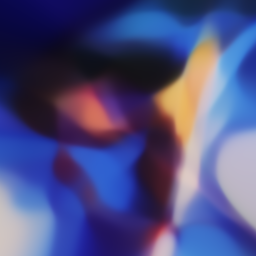

Saved checkpoint: xy_specnet_ckpt.pt
Loaded checkpoint: xy_specnet_ckpt.pt

=== Generating video for liability.wav ===
Spectrogram shape: torch.Size([601, 64])


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Saved 50/601 frames
Saved 100/601 frames
Saved 150/601 frames
Saved 200/601 frames
Saved 250/601 frames
Saved 300/601 frames
Saved 350/601 frames
Saved 400/601 frames
Saved 450/601 frames
Saved 500/601 frames
Saved 550/601 frames
Saved 600/601 frames
Creating video...
Adding audio...
✓ Video saved: liability_final.mp4


=== Generating video for one_last_kiss.wav ===
Spectrogram shape: torch.Size([301, 64])


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Saved 50/301 frames
Saved 100/301 frames
Saved 150/301 frames
Saved 200/301 frames
Saved 250/301 frames
Saved 300/301 frames
Creating video...
Adding audio...
✓ Video saved: one_last_kiss_final.mp4


=== Generating video for city_of_stars.wav ===
Spectrogram shape: torch.Size([271, 64])


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Saved 50/271 frames
Saved 100/271 frames
Saved 150/271 frames
Saved 200/271 frames
Saved 250/271 frames
Creating video...
Adding audio...
✓ Video saved: city_of_stars_final.mp4



In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import os
import subprocess
import shutil

from neural_network_music import XYSpecNet, make_mel_spec, normalize_spec, frames_to_video_with_audio
from RWraw import RW_Painter


# --------------------------
# 2) Parameters
# --------------------------
# Random-walk parameters 
steps_per_frame = 600     # how many strokes per video frame

# --------------------------
# Load checkpoint saved by test.py
# --------------------------

ckpt_path = "xy_specnet_ckpt.pt"
ckpt = torch.load(ckpt_path)

H = ckpt["H"]
W = ckpt["W"]
latent_size = ckpt["latent_size"]
hidden = ckpt["hidden"]
target_fps = ckpt["target_fps"]

spec_min = ckpt["spec_min"]
spec_max = ckpt["spec_max"]

model = XYSpecNet(spec_dim=latent_size, hidden=hidden)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print(f"Loaded checkpoint: {ckpt_path}")


# --------------------------
# 3) Generate frames with ALL audio files (random-walk)
# --------------------------
def generate_video_from_audio(audio_file, output_name):
    print(f"\n=== Generating video for {audio_file} ===")

    raw_spec = make_mel_spec(audio_file, latent_size, target_fps)

    # Apply SAME normalization as training
    spec, _, _ = normalize_spec(raw_spec, spec_min=spec_min, spec_max=spec_max)
    spec = spec.clamp(0.0, 1.0)

    print(f"Spectrogram shape: {spec.shape}")

    output_dir = f"frames_{output_name}"
    os.makedirs(output_dir, exist_ok=True)

    num_frames = spec.shape[0]

    painter = RW_Painter(model, W, H)
    painter.render(
        spec=spec,
        num_frames=num_frames,
        steps_per_frame=steps_per_frame,
        output_dir=output_dir
    )


    frames_to_video_with_audio(
        output_dir=output_dir,
        output_name=output_name,
        audio_file=audio_file,
        target_fps=target_fps
    )
    
audio_files = ["liability.wav", "one_last_kiss.wav", "city_of_stars.wav"]
for audio_file in audio_files:
    if os.path.exists(audio_file):
        output_name = audio_file.replace('.wav', '')
        generate_video_from_audio(audio_file, output_name)
    else:
        print(f"Warning: {audio_file} not found")
